<a href="https://colab.research.google.com/github/rht6226/DL/blob/main/UCI_Mobile_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the preprocessed datasets



In [ ]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [ ]:
class UciMobileDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'uci.npz') as data:
            self.trainX = data['trainX']
            self.trainy = to_categorical(data['trainy'])
            self.testX = data['testX']
            self.testy = to_categorical(data['testy'])

    def summary(self):
        print("UCI Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))


In [ ]:
uci = UciMobileDataset(filepath='/content/drive/My Drive/HAR Processed Data/UCI_HAR/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


# Training on 1D CNN Architecture


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [ ]:
def get_1DCNN_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [ ]:
# Summarising the model Architecture

model_1D_CNN = get_1DCNN_model(uci.trainX, uci.trainy, uci.testX, uci.testy)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 126, 64)           1792      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 126, 64)           4160      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 122, 64)           20544     
_________________________________________________________________
dropout_7 (Dropout)          (None, 122, 64)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3904)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)             

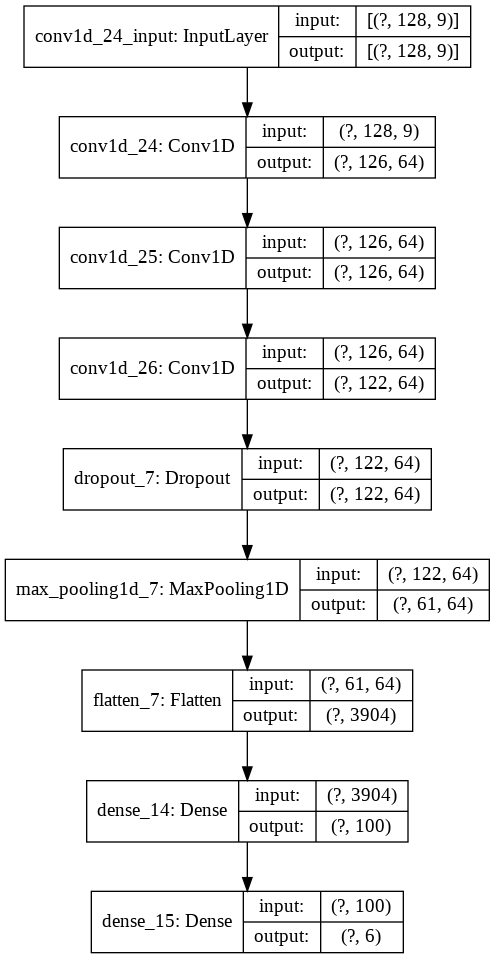

In [ ]:
plot_model(model_1D_CNN, show_shapes=True, show_layer_names=True)

In [ ]:
verbose, epochs, batch_size = 0, 10, 32
history_1D_CNN_UCI = model_1D_CNN.fit(uci.trainX, uci.trainy, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(uci.testX, uci.testy))

Epoch 1/10
230/230 [==============================] - 8s 34ms/step - loss: 0.3699 - accuracy: 0.8573 - val_loss: 0.3676 - val_accuracy: 0.8795
Epoch 2/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1347 - accuracy: 0.9442 - val_loss: 0.3355 - val_accuracy: 0.9125
Epoch 3/10
230/230 [==============================] - 8s 33ms/step - loss: 0.1144 - accuracy: 0.9529 - val_loss: 0.3439 - val_accuracy: 0.9080
Epoch 4/10
230/230 [==============================] - 8s 33ms/step - loss: 0.1154 - accuracy: 0.9536 - val_loss: 0.4346 - val_accuracy: 0.8639
Epoch 5/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1008 - accuracy: 0.9554 - val_loss: 0.3234 - val_accuracy: 0.8962
Epoch 6/10
230/230 [==============================] - 8s 34ms/step - loss: 0.1042 - accuracy: 0.9535 - val_loss: 0.3678 - val_accuracy: 0.9030
Epoch 7/10
230/230 [==============================] - 8s 34ms/step - loss: 0.0888 - accuracy: 0.9574 - val_loss: 0.3474 - val_accuracy: 0.9148

In [ ]:
_, accuracy = model_1D_CNN.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 1s 8ms/step - loss: 0.4183 - accuracy: 0.9108
0.9107567071914673


In [ ]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

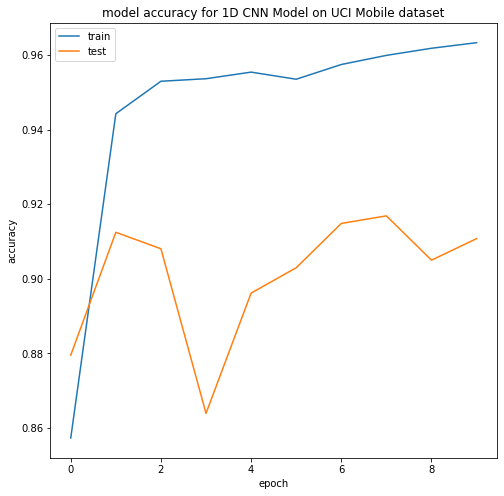

In [ ]:
plot_model_accuracy("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

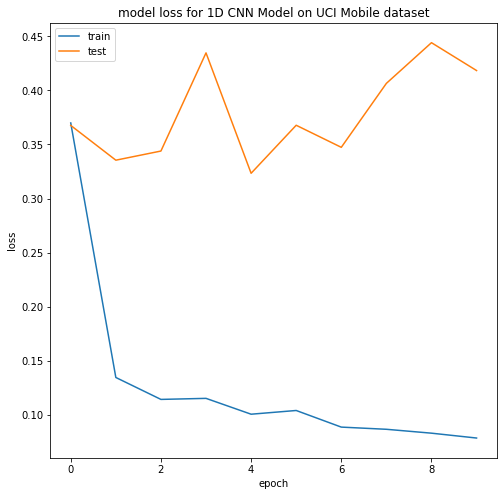

In [ ]:
plot_model_loss("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

# Training on Inception Architecture

In [ ]:
def Inception1D(input_layer, filter):
    # 1x1 Convolution
    conv_1x1 = Conv1D(filters=filter[0], kernel_size=1, activation='relu', padding='same')(input_layer)
    # 1x3 Convolution
    conv_1x3_reduce = Conv1D(filters=filter[1][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x3 = Conv1D(filters=filter[1][1], kernel_size=3, activation='relu', padding='same')(conv_1x3_reduce)
    # 1x5 Convolution
    conv_1x5_reduce = Conv1D(filters=filter[2][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x5 = Conv1D(filters=filter[2][1], kernel_size=5, activation='relu', padding='same')(conv_1x5_reduce)
    # 1x3 MaxPooling
    max_1x3 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_layer)
    max_conv_1x1 = Conv1D(filters=filter[3], kernel_size=1, activation='relu', padding='same')(max_1x3)
    # Concat
    output = Concatenate()([conv_1x1, conv_1x3, conv_1x5, max_conv_1x1])
    
    
    return output

In [ ]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

In [ ]:
def get_inception_model(input_shape, output_shape):
    ip_layer = Input(shape=input_shape)
    x = Inception1D(input_layer=ip_layer, filter=[32, (24, 64), (16, 32), 24])
    x = Inception1D(input_layer=x, filter=[48, (36, 64), (24, 48), 32])
    x = Inception1D(input_layer=x, filter=[32, (36, 64), (48, 72), 48])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Inception1D(x, [32, (24, 64), (24, 64), 24])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Flatten()(x)
    x = Dense(output_shape, activation='softmax')(x)

    model = Model(ip_layer, x, name='inception_HAR')

    return model

In [ ]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

model = get_inception_model(input_shape, output_shape)
model.summary()

Model: "inception_HAR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_365 (Conv1D)             (None, 128, 24)      240         input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_367 (Conv1D)             (None, 128, 16)      160         input_31[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_83 (MaxPooling1D) (None, 128, 9)       0           input_31[0][0]                   
______________________________________________________________________________________

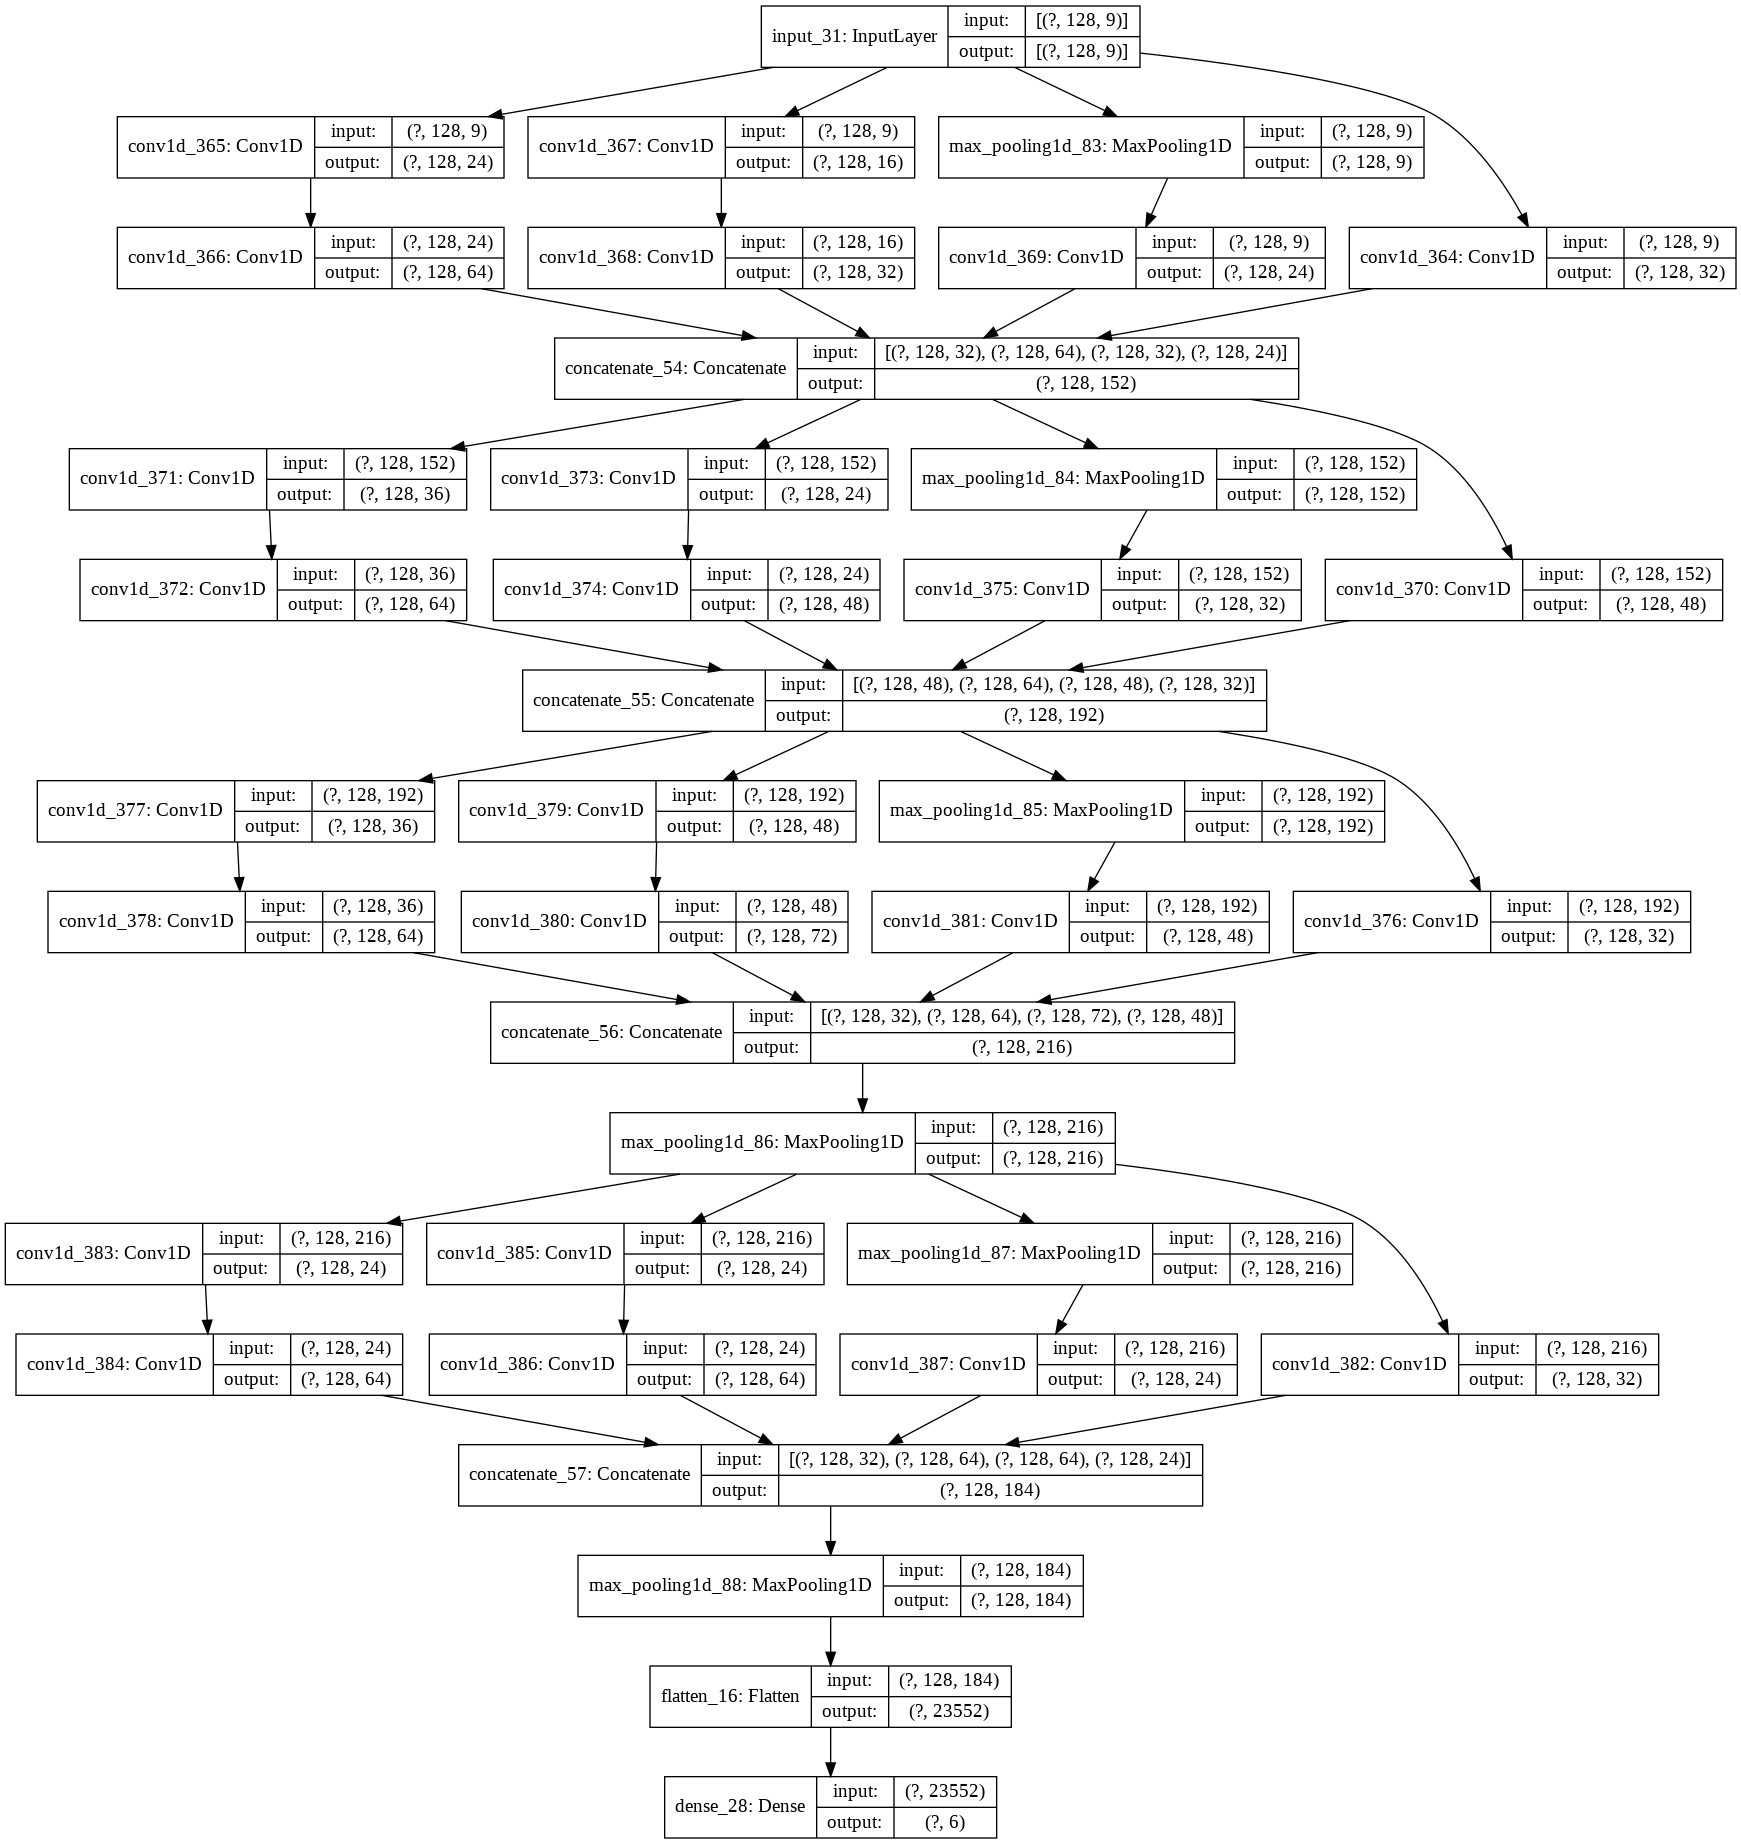

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x=uci.trainX, y=uci.trainy, validation_data=(uci.testX, uci.testy), verbose=1, batch_size=32, epochs=8)

Epoch 1/8
230/230 [==============================] - 46s 201ms/step - loss: 0.3561 - accuracy: 0.8557 - val_loss: 0.3359 - val_accuracy: 0.8931
Epoch 2/8
230/230 [==============================] - 46s 202ms/step - loss: 0.1351 - accuracy: 0.9421 - val_loss: 0.5424 - val_accuracy: 0.8653
Epoch 3/8
230/230 [==============================] - 46s 202ms/step - loss: 0.1249 - accuracy: 0.9471 - val_loss: 0.3952 - val_accuracy: 0.8962
Epoch 4/8
230/230 [==============================] - 46s 201ms/step - loss: 0.1082 - accuracy: 0.9525 - val_loss: 0.3551 - val_accuracy: 0.9223
Epoch 5/8
230/230 [==============================] - 46s 202ms/step - loss: 0.0996 - accuracy: 0.9565 - val_loss: 0.3737 - val_accuracy: 0.9006
Epoch 6/8
230/230 [==============================] - 46s 200ms/step - loss: 0.1149 - accuracy: 0.9510 - val_loss: 0.4417 - val_accuracy: 0.9135
Epoch 7/8
230/230 [==============================] - 46s 201ms/step - loss: 0.1080 - accuracy: 0.9539 - val_loss: 0.4166 - val_accuracy:

In [ ]:
_, accuracy = model.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 3s 36ms/step - loss: 0.3686 - accuracy: 0.9172
0.917203962802887


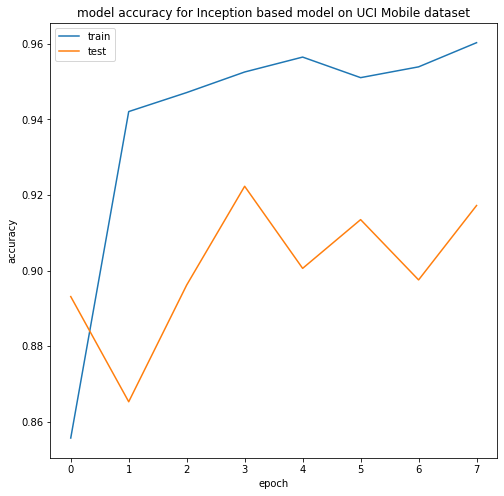

In [ ]:
plot_model_accuracy("Inception based model on UCI Mobile dataset", history=history)

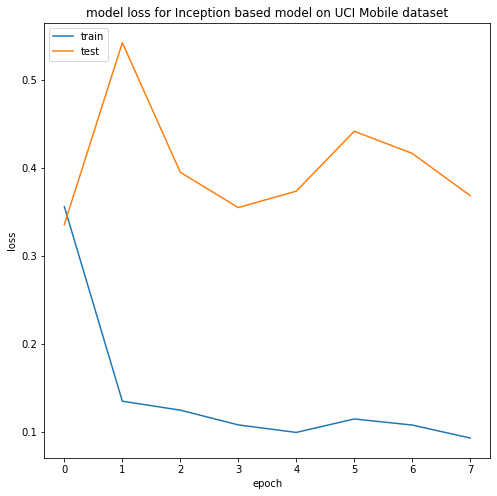

In [ ]:
plot_model_loss("Inception based model on UCI Mobile dataset", history=history)

# Plotting Confusion Matrices



In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


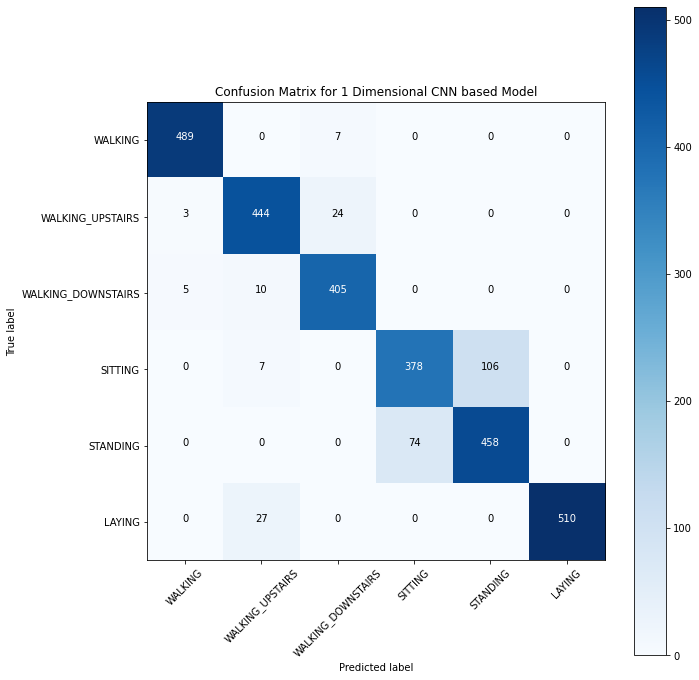

In [ ]:
# CNN Based Network
predictedY = model_1D_CNN.predict(uci.testX)
cm_plot_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for 1 Dimensional CNN based Model')

Confusion matrix, without normalization


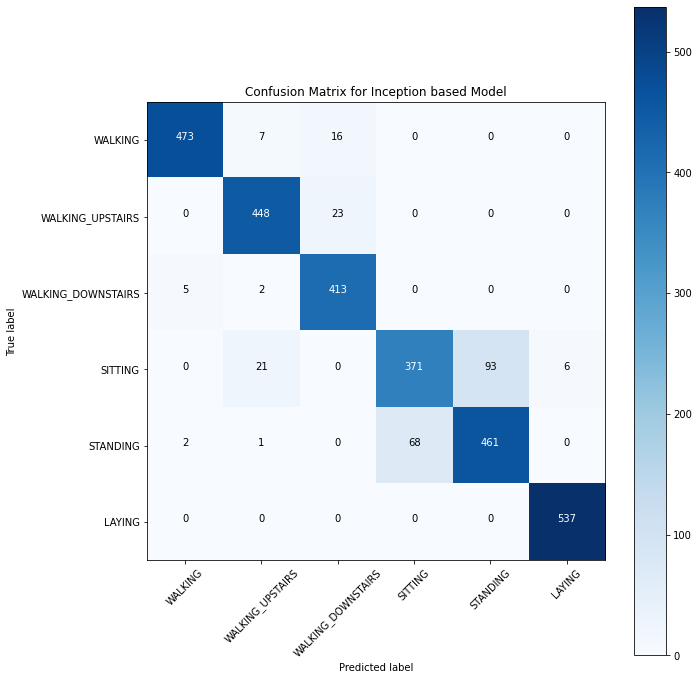

In [ ]:
# Inception Based Network
predictedY = model.predict(uci.testX)
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception based Model')

Confusion matrix, without normalization


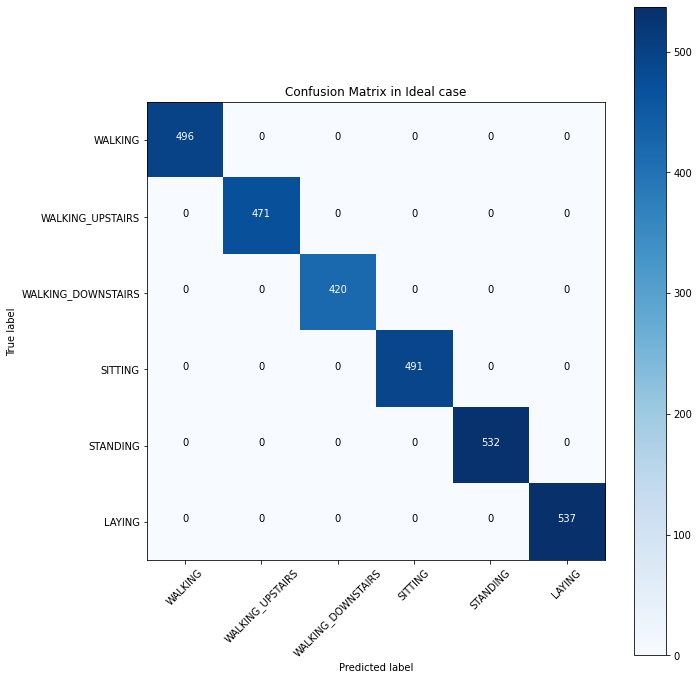

In [ ]:
plot_cm(uci.testy, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix in Ideal case')